In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

In [10]:
data = pd.read_csv('/content/diabetes_prediction_dataset.csv')
print(data.head())
print(data.info())
print(data.describe())


   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

               Feature          Chi2       P-value
0               gender    143.218251  7.953384e-32
1         hypertension   3910.708547  0.000000e+00
2        heart_disease   2945.847522  0.000000e+00
3      smoking_history   1932.615604  0.000000e+00
4  blood_glucose_level  38553.210263  0.000000e+00
               Feature  Cramér V
0               gender  0.037844
1         hypertension  0.197755
2        heart_disease  0.171635
3      smoking_history  0.139019
4  blood_glucose_level  0.620912
Cross-Validation Accuracy: 0.9467000000000001
Accuracy: 0.9471666666666667
Precision: 0.9350766456266907
Recall: 0.4066666666666667
F1 Score: 0.5668215359387812
ROC AUC: 0.8883503267973856


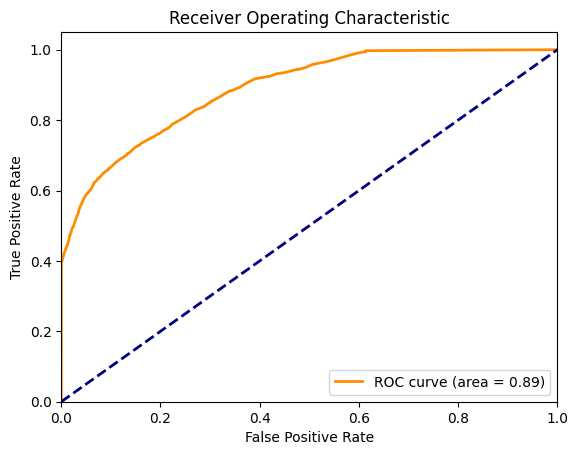

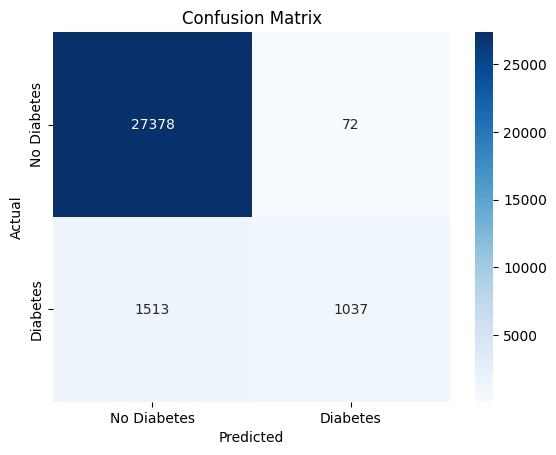

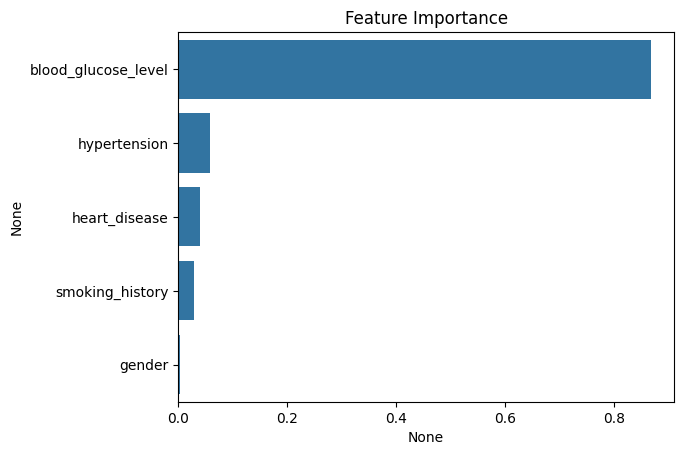

In [11]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])
data['smoking_history'] = label_encoder.fit_transform(data['smoking_history'])

# Perform Chi-Square test
def chi_square_test(data, target_column):
    chi2_results = []
    for column in data.columns:
        if column != target_column and data[column].dtype == 'int64':
            contingency_table = pd.crosstab(data[column], data[target_column])
            chi2, p, dof, ex = chi2_contingency(contingency_table)
            chi2_results.append((column, chi2, p))
    return chi2_results

chi2_results = chi_square_test(data, 'diabetes')
chi2_results = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'P-value'])
print(chi2_results)

# Perform Cramér's V test
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_v_results = []
for column in data.columns:
    if column != 'diabetes' and data[column].dtype == 'int64':
        contingency_table = pd.crosstab(data[column], data['diabetes'])
        cramer_v_value = cramers_v(contingency_table)
        cramers_v_results.append((column, cramer_v_value))

cramers_v_results = pd.DataFrame(cramers_v_results, columns=['Feature', 'Cramér V'])
print(cramers_v_results)

# Select significant features
significant_features = chi2_results[chi2_results['P-value'] < 0.05]['Feature'].tolist()
X = data[significant_features]
y = data['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Cross-validate the model
model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores)}')

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=significant_features).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.show()

Correlation between blood glucose level and age: 0.11067226757038093 (p-value: 5.637424276461014e-270)
Correlation between blood glucose level and BMI: 0.09126140154855851 (p-value: 6.811393645066744e-184)
Correlation between blood glucose level and hypertension: 0.08442890446963747 (p-value: 1.3673362283895698e-157)
                     blood_glucose_level       age       bmi  hypertension
blood_glucose_level             1.000000  0.110672  0.091261      0.084429
age                             0.110672  1.000000  0.337396      0.251171
bmi                             0.091261  0.337396  1.000000      0.147666
hypertension                    0.084429  0.251171  0.147666      1.000000


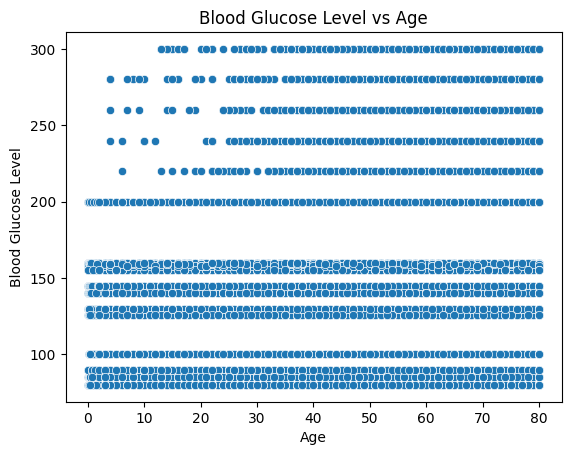

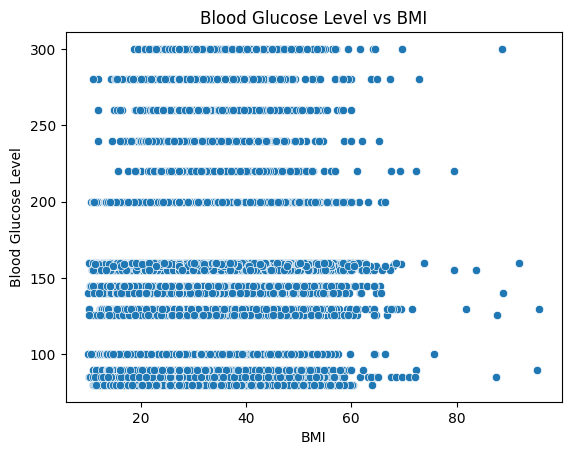

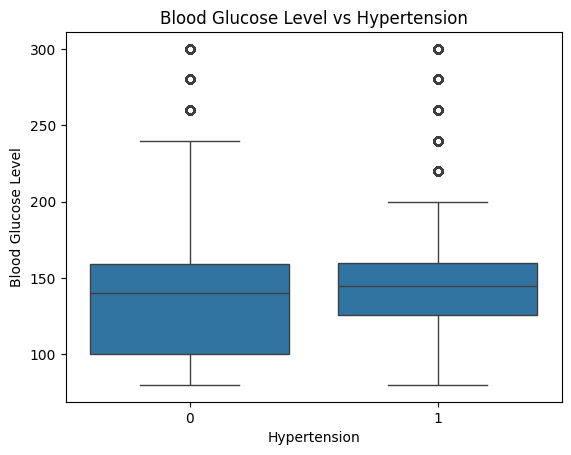

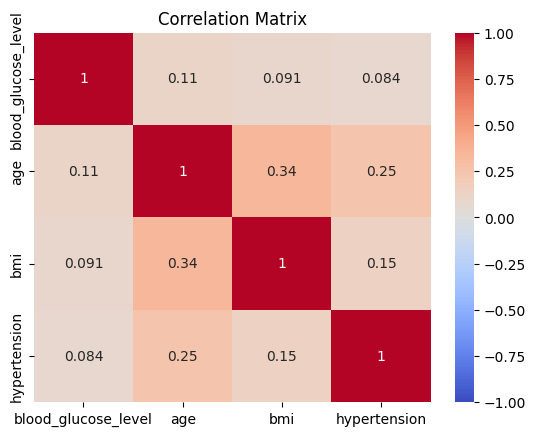

In [19]:
# Calculate Pearson correlation coefficients
correlation_age = pearsonr(data['blood_glucose_level'], data['age'])
correlation_bmi = pearsonr(data['blood_glucose_level'], data['bmi'])
correlation_hypertension = pearsonr(data['blood_glucose_level'], data['hypertension'])

print(f"Correlation between blood glucose level and age: {correlation_age[0]} (p-value: {correlation_age[1]})")
print(f"Correlation between blood glucose level and BMI: {correlation_bmi[0]} (p-value: {correlation_bmi[1]})")
print(f"Correlation between blood glucose level and hypertension: {correlation_hypertension[0]} (p-value: {correlation_hypertension[1]})")

# Generate correlation matrix
corr_matrix = data[['blood_glucose_level', 'age', 'bmi', 'hypertension']].corr()
print(corr_matrix)

# Visualize relationships using scatter plots
sns.scatterplot(x='age', y='blood_glucose_level', data=data)
plt.title('Blood Glucose Level vs Age')
plt.xlabel('Age')
plt.ylabel('Blood Glucose Level')
plt.show()

sns.scatterplot(x='bmi', y='blood_glucose_level', data=data)
plt.title('Blood Glucose Level vs BMI')
plt.xlabel('BMI')
plt.ylabel('Blood Glucose Level')
plt.show()

sns.boxplot(x='hypertension', y='blood_glucose_level', data=data)
plt.title('Blood Glucose Level vs Hypertension')
plt.xlabel('Hypertension')
plt.ylabel('Blood Glucose Level')
plt.show()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()